In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from networks import DiffusionNetwork
from data import LatinHyperCubeSampling
from loss_function import DiffusionLoss

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data=np.load(r'E:\Heat_diffusion_laser_metadata\30_Sep_2025_06_30_29_FBH13mm_step_size_sim_step_0_002m_p1.npz',allow_pickle=True)

Density: 1600 kg/m3 <br><br>
Specific heat capacity: 700 J/Kg*K <br><br>
Thermal conductivity kxx: 2.23 W/m*K<br><br>
Thermal conductivity kyy: 1.95 W/m*K<br><br>
Thermal conductivity kzz: 0.93 W/m*K

In [4]:
data=np.array(data['data'],dtype=np.float32)

In [5]:
data.shape

(409, 240, 320)

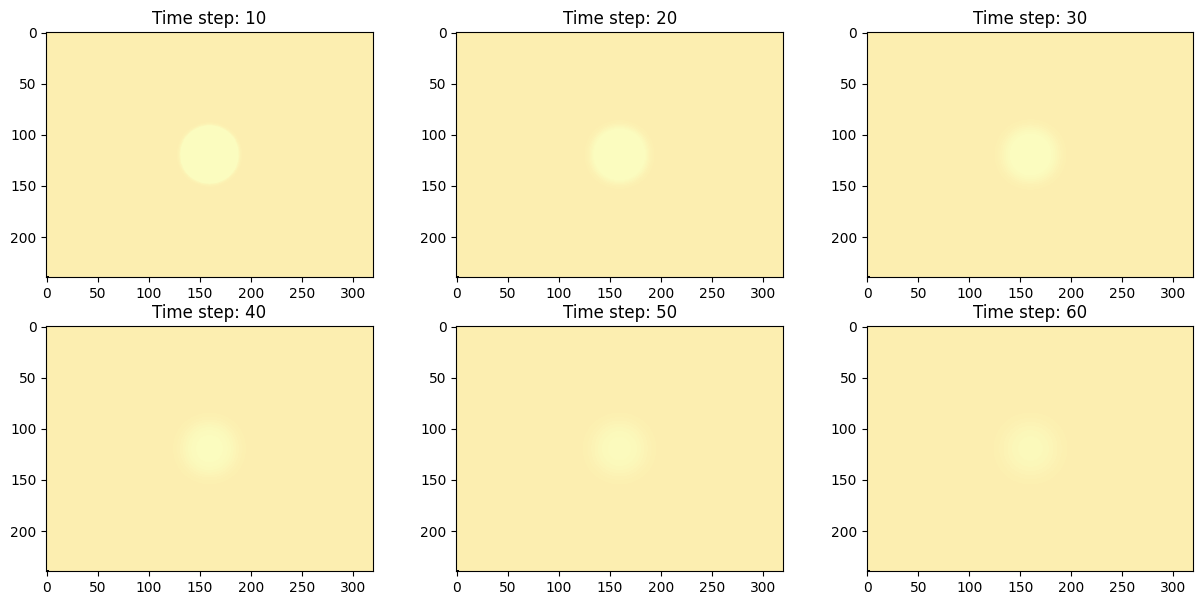

In [6]:
plt.figure(figsize=(15,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title(f'Time step: {i*10+10}')
    plt.imshow(data[i*10+10,:,:],cmap='magma',vmin=10000,vmax=30000)


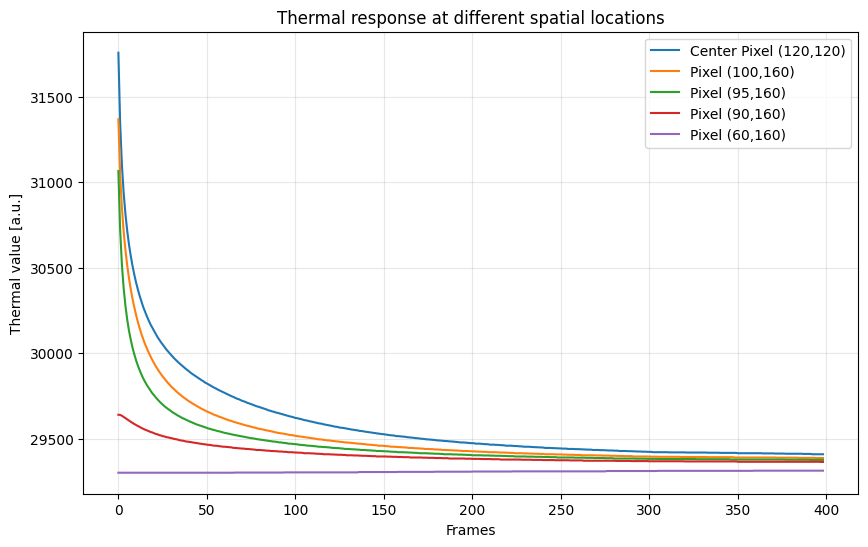

In [7]:
plt.figure(figsize=(10,6))
plt.plot(data[10:,120,160],label='Center Pixel (120,120)')
plt.plot(data[10:,100,160],label='Pixel (100,160)')
plt.plot(data[10:,95,160],label='Pixel (95,160)')
plt.plot(data[10:,90,160],label='Pixel (90,160)')
plt.plot(data[10:,60,160],label='Pixel (60,160)')
plt.grid(alpha=0.3)
plt.xlabel('Frames')
plt.ylabel('Thermal value [a.u.]')
plt.title('Thermal response at different spatial locations')
plt.legend()

In [8]:
data[10:,95:145,130:180].shape

(399, 50, 50)

In [9]:
model=DiffusionNetwork(
    input_size=3,
    output_size=1,
    hidden_layers=8,
    hidden_units=30,
    hidden_units_grad2=20
)

In [10]:
model=model.to(device)

In [11]:
sampler=LatinHyperCubeSampling((409,240,320))

In [12]:
physics_loss=DiffusionLoss()

In [13]:
model=DiffusionNetwork(
    input_size=3,
    output_size=1,
    hidden_layers=8,
    hidden_units=30,
    hidden_units_grad2=20
)

model=model.to(device)

sampler=LatinHyperCubeSampling((399,240,320))

coordis_data=sampler.lhs_tensor_indices(n_samples=100000,mode='interior',seed=42)
coordis_boundary=sampler.lhs_tensor_indices(n_samples=100000,mode='boundary',seed=42)

data=np.load(r'E:\Heat_diffusion_laser_metadata\30_Sep_2025_06_30_29_FBH13mm_step_size_sim_step_0_002m_p1.npz',allow_pickle=True)
data=np.array(data['data'],dtype=np.float32)
data=data[10:,:,:]  # Selection of cooling phase only

data=sampler.extract_values(data, coordis_data)

X=torch.from_numpy(data[:,:-1]).float().to(device)
X=X.requires_grad_(True)
y=torch.from_numpy(data[:,-1]).float().to(device)

In [14]:
y.size()

torch.Size([100000])

In [15]:
result,_=model(X)

In [16]:
result.size()

torch.Size([100000, 1])

In [17]:
model = DiffusionNetwork(
    input_size=3,
    output_size=1,
    hidden_layers=8,
    hidden_units=30,
    hidden_units_grad2=20
).to(device)

# 2️⃣ Load weights
checkpoint_path = "./checkpoints/adam_epoch_100000.pt"  # change to your file
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# 3️⃣ Set model to evaluation mode
model.eval()

print("✅ Model loaded successfully from:", checkpoint_path)

✅ Model loaded successfully from: ./checkpoints/adam_epoch_100000.pt


In [18]:
model.a_x

Parameter containing:
tensor([0.0197], device='cuda:0', requires_grad=True)

In [19]:
2.23/(1600*700)

1.9910714285714287e-06

In [20]:
model.a_y

Parameter containing:
tensor([0.0138], device='cuda:0', requires_grad=True)

In [21]:
1.95/(1600*700)

1.7410714285714286e-06

In [22]:
model.a_z

Parameter containing:
tensor([-2.4370e-10], device='cuda:0', requires_grad=True)

In [23]:
0.93/(1600*700)

8.303571428571429e-07

In [24]:
import os
import re

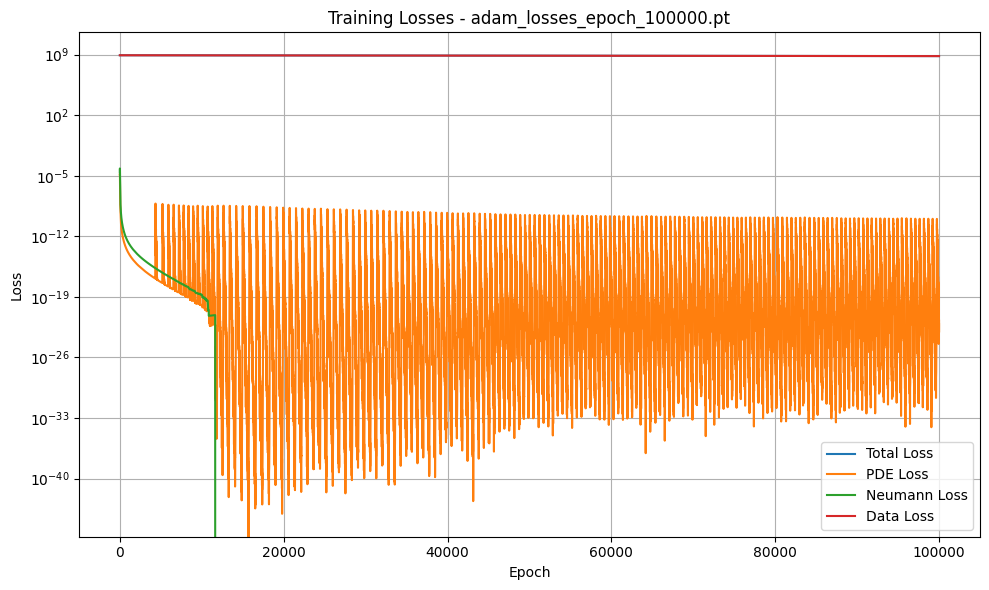

In [26]:
# --- Configure paths ---
log_dir = "logs"   # path to your logs folder
log_file = "adam_losses_epoch_100000.pt"  # choose one file to plot

# --- Load the log data ---
log_path = os.path.join(log_dir, log_file)
data = torch.load(log_path, map_location='cpu')

# --- Extract the losses ---
epochs = data['epochs']
pde_losses = data['pde_losses']
neumann_losses = data['neumann_losses']
data_losses = data['data_losses']
total_losses = data['total_losses']

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(epochs, total_losses, label='Total Loss')
plt.plot(epochs, pde_losses, label='PDE Loss')
plt.plot(epochs, neumann_losses, label='Neumann Loss')
plt.plot(epochs, data_losses, label='Data Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training Losses - {log_file}")
plt.yscale('log')  # optional: useful if losses span wide range
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()